# Réseaux de neurones artificielle (ANN)
**Aymen.B**

Cette partie à pour but d'explorer les de manière fondamentale et basique les réseaux de neurones qu'on connaît pour à terme atterir sur des modèles de pénalisation de ces ANN.

Je me repose sur l'article *"Training a neural network for data interpretation and better generalization: towards intelligent artificial intelligence"* de **Sylvain Sardy**, **Maxime van Custsem** et **Xiaoyu Ma**.

Ainsi que cette article : *"ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION"* de **Diederik P. Kingma** et **Jimmy Lei Ba**.

et pour bien comprendre cette vidéo : *"Optimization for Deep Learning (Momentum, RMSprop, AdaGrad, Adam)"* de 
**DeepBean** retrouvable [ici](https://www.youtube.com/watch?v=NE88eqLngkg&t=804s).

In [1]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS NON LINEAIRE\OUTILS")

## MLP from scratch

### MLP Simple avec descente de gradient

#### Théorie

##### Structure du réseau

On considère un MLP à $\ell$ couches, défini comme une composition de fonctions :

$$
\mu_\theta(x) = S_\ell \circ S_{\ell-1} \circ \dots \circ S_1(x)
$$

où chaque couche $k$ est définie par :

- une transformation affine : $z_k = W_k a_{k-1} + b_k$
- une activation non-linéaire $a_k = \sigma(z_k)$, sauf à la dernière couche (pas d’activation)

Les dimensions des objets sont :

- $x = a_0 \in \mathbb{R}^{p_1 \times m}$ : données d'entrée (features), $m$ est le nombre d'exemples
- $W_k \in \mathbb{R}^{p_{k+1} \times p_k}$ : poids de la couche $k$
- $b_k \in \mathbb{R}^{p_{k+1} \times 1}$ : biais de la couche $k$
- $z_k \in \mathbb{R}^{p_{k+1} \times m}$ : pré-activation
- $a_k \in \mathbb{R}^{p_{k+1} \times m}$ : post-activation

##### Propagation avant

Pour une entrée $x$, la propagation vers l’avant s’écrit récursivement :

$$
\begin{aligned}
z_1 &= W_1 x + b_1 \\
a_1 &= \sigma(z_1) \\
z_2 &= W_2 a_1 + b_2 \\
a_2 &= \sigma(z_2) \\
\vdots \\
z_\ell &= W_\ell a_{\ell-1} + b_\ell \\
a_\ell &= z_\ell \quad \text{(pas d’activation en sortie)}
\end{aligned}
$$

La sortie finale est $\hat{y} = \mu_\theta(x) = a_\ell$.

##### Rétropropagation (Backward pass)

On calcule les gradients $\nabla_{W_k} \mathcal{L}$ et $\nabla_{b_k} \mathcal{L}$ via la règle de la chaîne.

On pose :
- $\delta_\ell := \frac{\partial \mathcal{L}}{\partial z_\ell} = \frac{\partial \mathcal{L}}{\partial \hat{y}}$ (pas d’activation à la dernière couche)

Ensuite, pour $k = \ell-1, \dots, 1$ :

$$
\delta_k = (W_{k+1}^T \delta_{k+1}) \odot \sigma'(z_k)
$$

Les gradients s’écrivent alors :

$$
\nabla_{W_k} \mathcal{L} = \delta_k \cdot a_{k-1}^T \\
\nabla_{b_k} \mathcal{L} = \sum_{i=1}^m \delta_k^{(i)} \quad \text{(somme des colonnes)}
$$

##### Mise à jour par descente de gradient (SGD)

Soit $\eta$ le taux d’apprentissage (learning rate), les poids sont mis à jour via :

$$
W_k \leftarrow W_k - \eta \cdot \nabla_{W_k} \mathcal{L} \\
b_k \leftarrow b_k - \eta \cdot \nabla_{b_k} \mathcal{L}
$$

##### Initialisation

Les poids $W_k$ sont initialisés par une loi normale centrée réduite avec un facteur d’échelle de He :

$$
W_k \sim \mathcal{N}(0, \frac{2}{p_k})
$$

Les biais $b_k$ sont initialisés à zéro.

#### Test

Test simple dans le cas d'une régression simple (approximer $y = sin(x)$ )

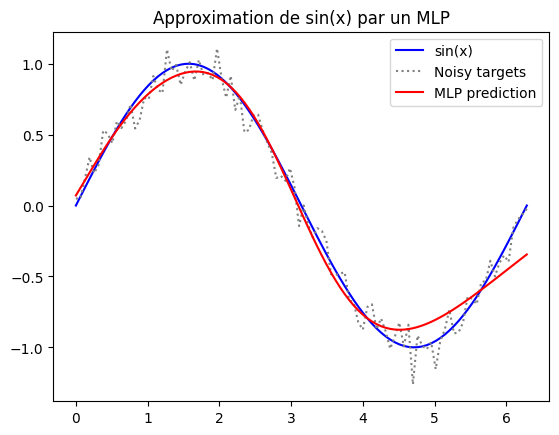

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mlp import MLP

np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
y = np.sin(X)

y_noisy = y + 0.1 * np.random.randn(*y.shape)

model_sgd = MLP(
    layer_sizes=[1, 10, 1],
    optimizer="sgd",
    seed=42
)

model_sgd.train(
    X=X.T,
    Y=y_noisy.T,
    epochs=10000,
    lr=0.01,
    batch_size=10,
    verbose=False
)

y_pred = model_sgd(X.T)

plt.plot(X, y, label="sin(x)", color="blue")
plt.plot(X, y_noisy, label="Noisy targets", linestyle="dotted", color="gray")
plt.plot(X, y_pred.flatten(), label="MLP prediction", color="red")
plt.legend()
plt.title("Approximation de sin(x) par un MLP")
plt.show()

Test simple dans le cas d'une régression linéaire (approximer y = $3x_1 - 2x_2$ )

In [3]:
# Générer des données linéaires : y = 3x1 - 2x2 + bruit
np.random.seed(0)
n = 200
X = np.random.randn(2, n)
true_w = np.array([[3, -2]])
y = true_w @ X + 0.05 * np.random.randn(1, n)

# MLP pour régression linéaire
class Identity:
    def __call__(self, u):
        return u
    def grad(self, u):
        return np.ones_like(u)

model = MLP(
    layer_sizes=[2, 1],
    activation=Identity(),
    seed=0
)

# Entraînement
model.train(
    X=X,
    Y=y,
    epochs=5000,
    lr=0.01,
    batch_size=n,
    shuffle=False,
    verbose=False
)

W_learned = model.W[0]
b_learned = model.b[0]

print("Poids appris :", W_learned.flatten())
print("Poids théoriques :", true_w.flatten())
print("Biais appris :", b_learned.flatten())
error = np.linalg.norm(W_learned - true_w)
print(f"Erreur sur les poids : {error:.6f}")

Poids appris : [ 2.99640957 -1.98994116]
Poids théoriques : [ 3 -2]
Biais appris : [-0.0038451]
Erreur sur les poids : 0.010680


### MLP avec optimisation ADAM

#### Théorie

##### Mise à jour par **Adam**

Adam (*Adaptive Moment Estimation*) combine l’idée du **momentum** (moyenne exponentielle des gradients) et celle de **RMSProp** (moyenne exponentielle des carrés de gradients) pour ajuster automatiquement le pas de chaque paramètre.

*Paramètres* :  
- taux d’apprentissage $\displaystyle \eta$ (souvent $\eta = 10^{-3}$)  
- $\beta_1 = 0{,}9$ pour la moyenne des gradients  
- $\beta_2 = 0{,}999$ pour la moyenne des carrés de gradients  
- $\varepsilon = 10^{-8}$ pour stabiliser la division

À l’itération $t$ pour la couche $k$ :

1. **Moments non corrigés**  
   $$
   \begin{aligned}
   m^{(t)}_{W_k} &= \beta_1 \, m^{(t-1)}_{W_k} + (1-\beta_1)\,\nabla_{W_k}\mathcal{L} \\
   v^{(t)}_{W_k} &= \beta_2 \, v^{(t-1)}_{W_k} + (1-\beta_2)\,\bigl(\nabla_{W_k}\mathcal{L}\bigr)^2
   \end{aligned}
   $$

   (mêmes formules pour $m^{(t)}_{b_k}$ et $v^{(t)}_{b_k}$).

2. **Corrections de biais**  
   $$
   \hat{m}^{(t)}_{W_k} = \frac{m^{(t)}_{W_k}}{1-\beta_1^{\,t}}, 
   \qquad
   \hat{v}^{(t)}_{W_k} = \frac{v^{(t)}_{W_k}}{1-\beta_2^{\,t}}
   $$

3. **Mise à jour des paramètres**  
   $$
   W_k \;\leftarrow\; W_k 
   \;-\; \eta \,\frac{\hat{m}^{(t)}_{W_k}}{\sqrt{\hat{v}^{(t)}_{W_k}} + \varepsilon}
   \qquad\text{et}\qquad
   b_k \;\leftarrow\; b_k 
   \;-\; \eta \,\frac{\hat{m}^{(t)}_{b_k}}{\sqrt{\hat{v}^{(t)}_{b_k}} + \varepsilon}
   $$

Ainsi, Adam adapte le **pas d’apprentissage** individuellement pour chaque poids : les dimensions dont les gradients varient beaucoup reçoivent un pas plus petit, tandis que celles aux gradients stables conservent un pas plus grand.

#### Test

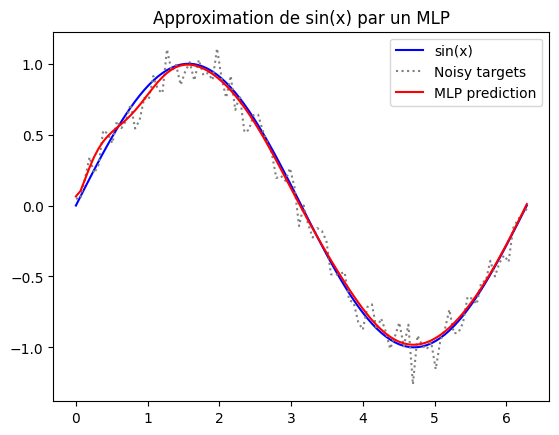

: 

In [ ]:
np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
y = np.sin(X)

y_noisy = y + 0.1 * np.random.randn(*y.shape)

model_adam = MLP(
    layer_sizes=[1, 10, 1],
    optimizer="adam",
    seed=42
)

model_adam.train(
    X=X.T,
    Y=y_noisy.T,
    epochs=10000,
    lr=0.01,
    batch_size=10,
    verbose=False
)

y_pred = model_adam(X.T)

plt.plot(X, y, label="sin(x)", color="blue")
plt.plot(X, y_noisy, label="Noisy targets", linestyle="dotted", color="gray")
plt.plot(X, y_pred.flatten(), label="MLP prediction", color="red")
plt.legend()
plt.title("Approximation de sin(x) par un MLP")
plt.show()

## MLP avec pytorch 
pour aller toujours plus vite, toujours plus loin !

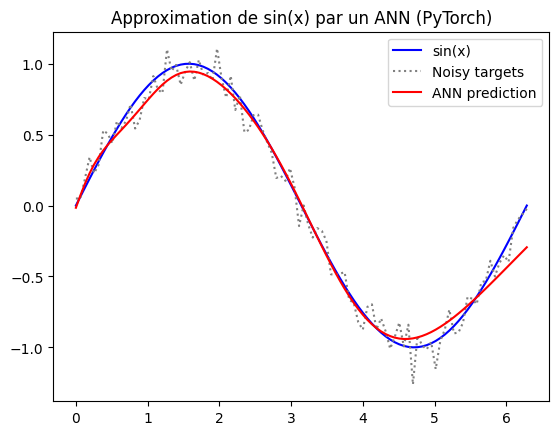

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from ann import ANN

np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
y = np.sin(X)

y_noisy = y + 0.1 * np.random.randn(*y.shape)

X_torch = torch.from_numpy(X.astype(np.float32))
y_noisy_torch = torch.from_numpy(y_noisy.astype(np.float32))

model_ann = ANN(layer_sizes=[1, 10, 1], activation=torch.nn.Sigmoid)

model_ann.train(
    X=X_torch,
    Y=y_noisy_torch,
    epochs=1000,
    lr=0.01)

with torch.no_grad():
    y_pred = model_ann(X_torch)

plt.plot(X, y, label="sin(x)", color="blue")
plt.plot(X, y_noisy, label="Noisy targets", linestyle="dotted", color="gray")
plt.plot(X, y_pred.flatten(), label="ANN prediction", color="red")
plt.legend()
plt.title("Approximation de sin(x) par un ANN (PyTorch)")
plt.show()